# Step 3 - Accepted Loans EDA

## Goals in this Notebook

Explore the accepted loans dataset:
- Clean up the dataset, if required.
- Perform EDA.
- Practice performing statistical inference.

## Initialisation

### Dependancies and Data 

In [1]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions
import constants
from sklearn.model_selection import train_test_split
import scipy.stats as stats

sns.set_palette("colorblind", 10)

In [2]:
acc_train_path = os.path.join("data", "acc_train.parquet")
df_acc = pl.read_parquet(acc_train_path)
df_acc = (
    df_acc.pipe(functions.parse_to_datetime, col="issue_d", fmt="%b-%Y")
    .drop("issue_d")
    .pipe(functions.parse_to_datetime, col="earliest_cr_line", fmt="%b-%Y")
    .drop("earliest_cr_line")
    .pipe(functions.parse_to_datetime, col="sec_app_earliest_cr_line", fmt="%b-%Y")
    .drop("sec_app_earliest_cr_line")
    .pipe(functions.add_year_month, date_col="issue_d_parsed")
    .pipe(functions.add_year_month, date_col="earliest_cr_line_parsed")
    .pipe(functions.add_year_month, date_col="sec_app_earliest_cr_line_parsed")
)
HEIGHT = df_acc.height

### Feature Clean-up

There're several date columns in the dataset. Let's see if they are meaningful.

In [3]:
df_acc_parsed_dates = (
    df_acc.pipe(functions.parse_to_datetime, col="hardship_start_date", fmt="%b-%Y")
    .pipe(functions.parse_to_datetime, col="hardship_end_date", fmt="%b-%Y")
    .pipe(functions.parse_to_datetime, col="debt_settlement_flag_date", fmt="%b-%Y")
    .pipe(functions.parse_to_datetime, col="settlement_date", fmt="%b-%Y")
    .pipe(functions.parse_to_datetime, col="payment_plan_start_date", fmt="%b-%Y")
)
functions.earlier_than_issue_date(df_acc_parsed_dates, "hardship_start_date_parsed")
functions.earlier_than_issue_date(df_acc_parsed_dates, "hardship_end_date_parsed")
functions.earlier_than_issue_date(
    df_acc_parsed_dates, "debt_settlement_flag_date_parsed"
)
functions.earlier_than_issue_date(df_acc_parsed_dates, "settlement_date_parsed")
functions.earlier_than_issue_date(df_acc_parsed_dates, "payment_plan_start_date_parsed")

There're 0 instances where hardship_start_date_parsed is before issue_d_parsed
There're 0 instances where hardship_end_date_parsed is before issue_d_parsed
There're 0 instances where debt_settlement_flag_date_parsed is before issue_d_parsed
There're 0 instances where settlement_date_parsed is before issue_d_parsed
There're 0 instances where payment_plan_start_date_parsed is before issue_d_parsed


Since these events happen after the loan is issued, all of these dates and associated features should be dropped as they will not help predict the target. They could be used for a different goal, ie to analyse what loans get payed out successfully.

Refer to ./data/acc_features.xslx for detailed descriptions of the features. I have used ChatGPT to understand what each of the features mean. Even though these descriptions could be erroneous, it's the best guess I have when selecting which features to drop.

Next, let's drop the identified leaky features and explore null values.

In [4]:
excel_path = os.path.join("data", "acc_features.xlsx")
excel_to_drop = functions.get_excel_drop_features(excel_path)

df_acc = df_acc.drop(excel_to_drop)

print("Features that have more than 40% null values")
df_acc.null_count().transpose(include_header=True).filter(
    pl.col("column_0") > HEIGHT * 0.4
).to_numpy()

Features that have more than 40% null values


array([['mths_since_last_delinq', 1056665],
       ['mths_since_last_record', 1737755],
       ['mths_since_last_major_derog', 1535655],
       ['annual_inc_joint', 1964960],
       ['dti_joint', 1964962],
       ['verification_status_joint', 1968613],
       ['mths_since_rcnt_il', 861689],
       ['il_util', 1003184],
       ['mths_since_recent_bc_dlq', 1591277],
       ['mths_since_recent_revol_delinq', 1388633],
       ['revol_bal_joint', 1977008],
       ['sec_app_fico_range_low', 1977007],
       ['sec_app_fico_range_high', 1977007],
       ['sec_app_inq_last_6mths', 1977007],
       ['sec_app_mort_acc', 1977007],
       ['sec_app_open_acc', 1977007],
       ['sec_app_revol_util', 1978618],
       ['sec_app_open_act_il', 1977007],
       ['sec_app_num_rev_accts', 1977007],
       ['sec_app_chargeoff_within_12_mths', 1977007],
       ['sec_app_collections_12_mths_ex_med', 1977007],
       ['sec_app_mths_since_last_major_derog', 2038482],
       ['sec_app_earliest_cr_line_parsed', 1

In most cases the missing values could be MNAR. The values could be missing for the second applicant because there is no second applicant. The values for months since last delinquency could be missing because the applicant never had one and that should reduce the risk of the loan.

We have a lot of features in the dataset. For EDA, it may not be fitting to start with univariate analysis of each of the features. Let's calculate correlation with our targets (grade, subgrade, interest rate) as an importance measure of the different features. But first, let's draw a stratified sample on grade.

In [5]:
df_acc_sample, _ = train_test_split(
    df_acc,
    test_size=0.9,
    stratify=df_acc.select("grade"),
    shuffle=True,
    random_state=42,
)
df_acc_sample.shape

(206951, 111)

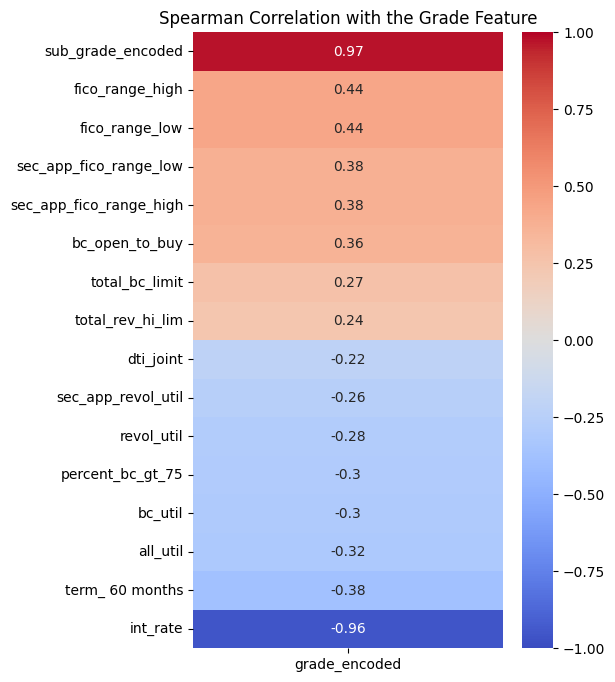

In [6]:
df_acc_sample_corr = (
    df_acc_sample.pipe(
        functions.encode_binary_cols_for_EDA, binary_cols=constants.binary_cols
    )
    .pipe(
        functions.encode_ordinal_col_polars,
        col="emp_length",
        order=constants.emp_length_order,
    )
    .pipe(
        functions.encode_ordinal_col_polars,
        col="verification_status",
        order=constants.verification_order,
    )
    .pipe(
        functions.encode_ordinal_col_polars,
        col="verification_status_joint",
        order=constants.verification_order,
    )
    .pipe(functions.encode_ordinal_col_polars, col="grade", order=constants.grade_order)
    .pipe(
        functions.encode_ordinal_col_polars,
        col="sub_grade",
        order=constants.subgrade_order,
    )
    .pipe(functions.cast_wrong_str, cols=constants.wrong_str_to_cast)
)

plt.figure(figsize=(5, 8))
functions.correlation_bar(
    df_acc_sample_corr.to_pandas(),
    "grade_encoded",
    "Spearman Correlation with the Grade Feature",
    imp_filter=0.2,
    method="spearman",
    numeric_only=True,
)

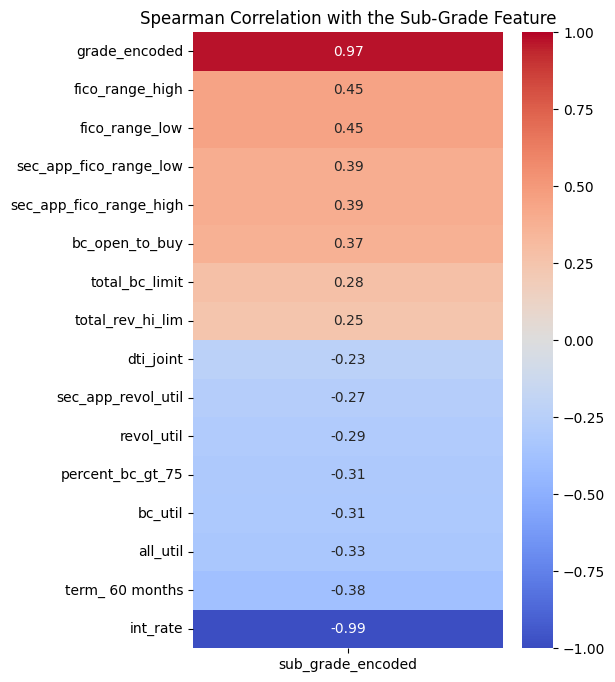

In [7]:
plt.figure(figsize=(5, 8))
functions.correlation_bar(
    df_acc_sample_corr.to_pandas(),
    "sub_grade_encoded",
    "Spearman Correlation with the Sub-Grade Feature",
    imp_filter=0.2,
    method="spearman",
    numeric_only=True,
)

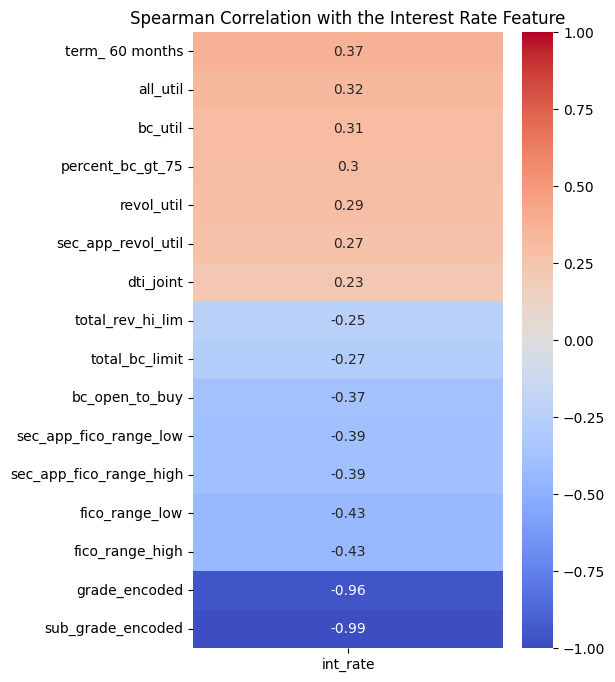

In [8]:
plt.figure(figsize=(5, 8))
functions.correlation_bar(
    df_acc_sample_corr.to_pandas(),
    "int_rate",
    "Spearman Correlation with the Interest Rate Feature",
    imp_filter=0.2,
    method="spearman",
    numeric_only=True,
)

Clearly, the three targets are very closely correlated. We can also see the features that we'd want to start our EDA with.

Since we started with correlation, it could also be a good idea to check for collinearity between the features.

In [9]:
print("Top Correlations")
h_corr_pairs = functions.get_high_corr_pairs(df_acc_sample_corr.to_pandas())
h_corr_pairs

Top Correlations


fico_range_low          fico_range_high               1.000000
sec_app_fico_range_low  sec_app_fico_range_high       1.000000
open_acc                num_sats                      0.998694
num_actv_rev_tl         num_rev_tl_bal_gt_0           0.990919
id                      issue_d_parsed_year           0.983468
tot_cur_bal             tot_hi_cred_lim               0.972131
grade_encoded           sub_grade_encoded             0.971026
total_bal_il            total_il_high_credit_limit    0.955405
tot_cur_bal             avg_cur_bal                   0.925989
dtype: float64

Two feature pairs have exact correlation, while others have very strong correlations. We will consider dropping them.

In [10]:
df_acc_sample = (
    df_acc_sample.pipe(functions.cast_wrong_str, cols=constants.wrong_str_to_cast)
    .drop(constants.high_corr_to_drop)
    .fill_null("None")
)

### EDA

#### Targets' Distributions

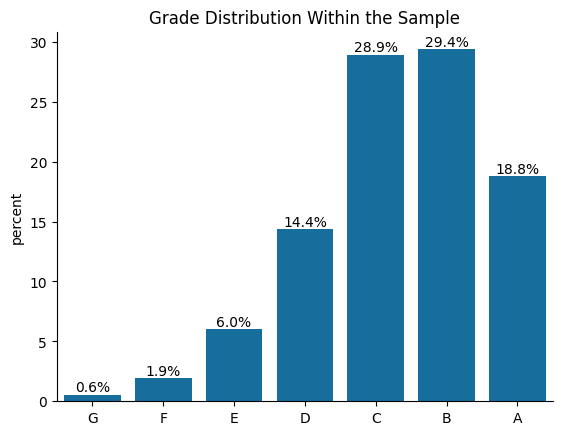

In [11]:
sns.countplot(
    x=df_acc_sample.select("grade").to_series(),
    stat="percent",
    order=constants.grade_order,
)
functions.add_labels(fmt="%.1f%%")
plt.xlabel("")
plt.title("Grade Distribution Within the Sample")
sns.despine()

Most of the dataset contains quite high-grade loans, with very few instances of lowest grade G.

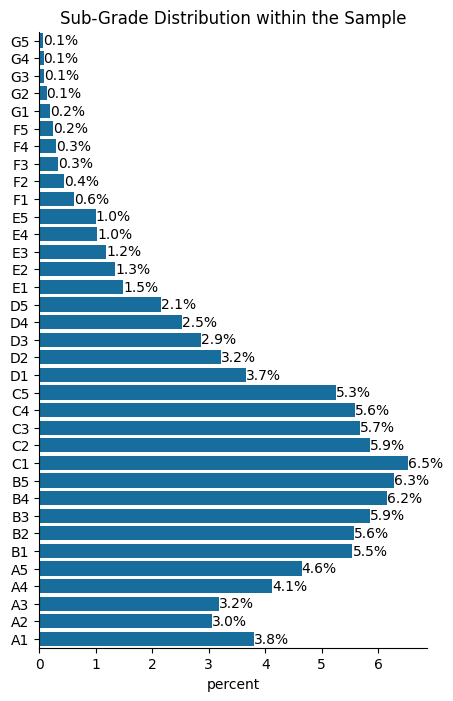

In [12]:
plt.figure(figsize=(5, 8))
sns.countplot(
    y=df_acc_sample.select("sub_grade").to_series(),
    stat="percent",
    order=constants.subgrade_order,
)
functions.add_labels(fmt="%.1f%%")
plt.title("Sub-Grade Distribution within the Sample")
plt.ylabel("")
sns.despine()

Here, the proportions looks even more extreme when considering loans of G subgrades. It may be hard modelling these lower-grade loans.

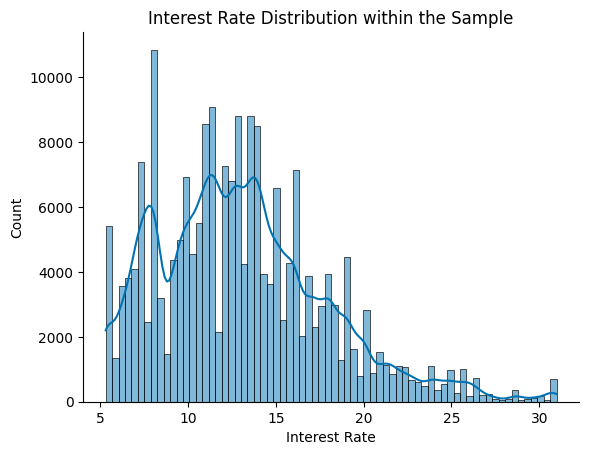

In [13]:
sns.histplot(df_acc_sample.select("int_rate"), kde=True, bins=70, legend=False)
plt.title("Interest Rate Distribution within the Sample")
plt.xlabel("Interest Rate")
sns.despine()

Interest rate is quite vast, starting at around 5 and ending at around 30. We have few examples of high interest loans, because we have few examples of low-grade loans.

### Features' Interactions with the Target

We'll be using grade as the target here - the plots will look more visually appealing with 7 classes instead of 35.

#### Loan Term

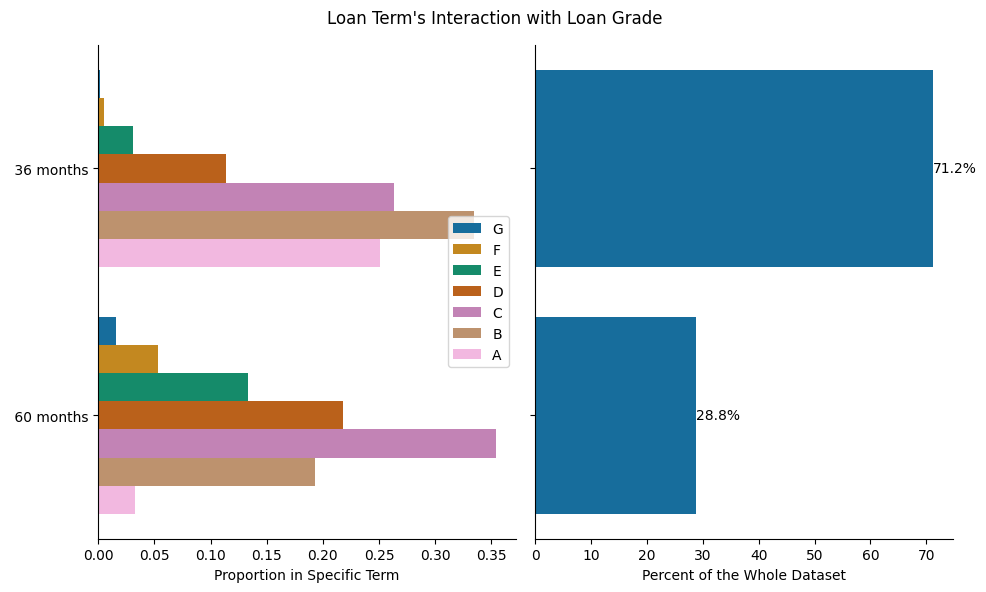

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(
    df_acc_sample, x="term", hue="grade", hue_order=constants.grade_order, ax=ax
)
ax[0].set_xlabel("Proportion in Specific Term")
ax[0].set_ylabel("")
ax[0].legend(loc="right")
ax[1].set_xlabel("Percent of the Whole Dataset")
plt.suptitle("Loan Term's Interaction with Loan Grade")
fig.tight_layout()

36 month term loans are usually graded better.

#### FICO Score

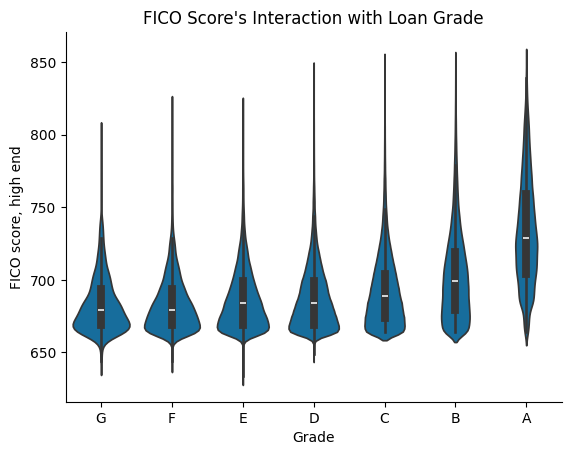

In [15]:
sns.violinplot(
    data=df_acc_sample.select(["fico_range_high", "grade"]),
    y="fico_range_high",
    x="grade",
    order=constants.grade_order,
)
plt.title("FICO Score's Interaction with Loan Grade")
plt.xlabel("Grade")
plt.ylabel("FICO score, high end")
sns.despine()

In [16]:
print("total_bc_limit for fico_range_high feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="fico_range_high")

total_bc_limit for fico_range_high feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",664.0,704.0,729.0,759.0,850.0,38889,0,0.0
"""B""",664.0,679.0,699.0,719.0,850.0,60804,0,0.0
"""C""",664.0,674.0,689.0,704.0,850.0,59856,0,0.0
"""D""",649.0,669.0,684.0,699.0,844.0,29783,0,0.0
"""E""",634.0,669.0,684.0,699.0,819.0,12500,0,0.0
"""F""",644.0,669.0,679.0,694.0,819.0,3965,0,0.0
"""G""",644.0,669.0,679.0,694.0,799.0,1154,0,0.0


It seems that FICO score starts playing a role after grade E or even D.

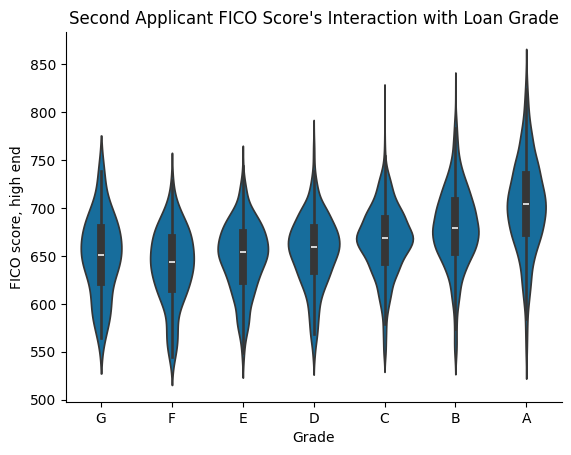

In [17]:
sns.violinplot(
    data=df_acc_sample.select(["sec_app_fico_range_high", "grade"]),
    y="sec_app_fico_range_high",
    x="grade",
    order=constants.grade_order,
)
plt.title("Second Applicant FICO Score's Interaction with Loan Grade")
plt.xlabel("Grade")
plt.ylabel("FICO score, high end")
sns.despine()

In [18]:
print("Aggregations for sec_app_fico_range_high feature")
functions.aggregations_by_group(
    df_acc_sample, by="grade", agg_for="sec_app_fico_range_high"
)

Aggregations for sec_app_fico_range_high feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",544.0,674.0,704.0,734.0,844.0,38889,37126,0.954666
"""B""",544.0,654.0,679.0,709.0,824.0,60804,58254,0.958062
"""C""",544.0,644.0,669.0,689.0,814.0,59856,57048,0.953087
"""D""",544.0,634.0,659.0,679.0,774.0,29783,28443,0.955008
"""E""",544.0,624.0,654.0,674.0,744.0,12500,11995,0.9596
"""F""",544.0,614.0,644.0,669.0,729.0,3965,3815,0.962169
"""G""",564.0,624.0,651.5,679.0,739.0,1154,1094,0.948007


Secondary applicant FICO score is null most of the time, but a higher score would usually get a higher grade loan.

#### Bankcard Credit Amount

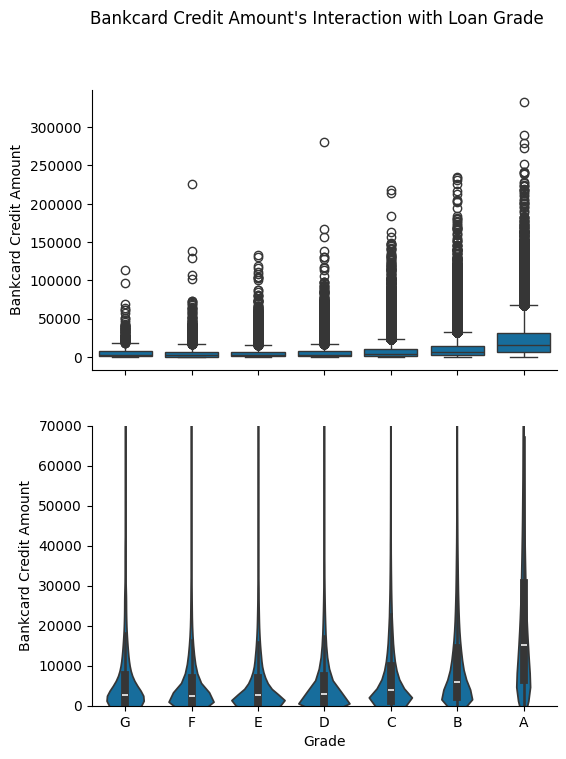

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
sns.boxplot(
    data=df_acc_sample.select(["bc_open_to_buy", "grade"]),
    y="bc_open_to_buy",
    x="grade",
    ax=ax[0],
    order=constants.grade_order,
)
sns.violinplot(
    data=df_acc_sample.select(["bc_open_to_buy", "grade"]),
    y="bc_open_to_buy",
    x="grade",
    ax=ax[1],
    order=constants.grade_order,
)
ax[0].set_ylabel("Bankcard Credit Amount")
ax[1].set_ylabel("Bankcard Credit Amount")
ax[1].set_xlabel("Grade")
ax[1].set_ylim(0, 70_000)
plt.suptitle("Bankcard Credit Amount's Interaction with Loan Grade")
sns.despine()

In [20]:
print("Aggregations for bc_open_to_buy feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="bc_open_to_buy")

Aggregations for bc_open_to_buy feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,6390.0,15173.5,30738.0,332178.0,38889,1375,0.035357
"""B""",0.0,2154.0,6053.0,14362.0,235410.0,60804,1930,0.031741
"""C""",0.0,1257.0,3950.0,9891.0,218231.0,59856,1689,0.028218
"""D""",0.0,871.0,2946.0,7497.0,281029.0,29783,1116,0.037471
"""E""",0.0,713.0,2579.0,6810.0,133006.0,12500,590,0.0472
"""F""",0.0,625.0,2469.0,6978.0,225389.0,3965,224,0.056494
"""G""",0.0,777.0,2786.5,7743.0,113231.0,1154,68,0.058925


Higher bankcard credit amount gives better grade. Also, lower-grade loans have a higher null proportion.

#### Credit Limit

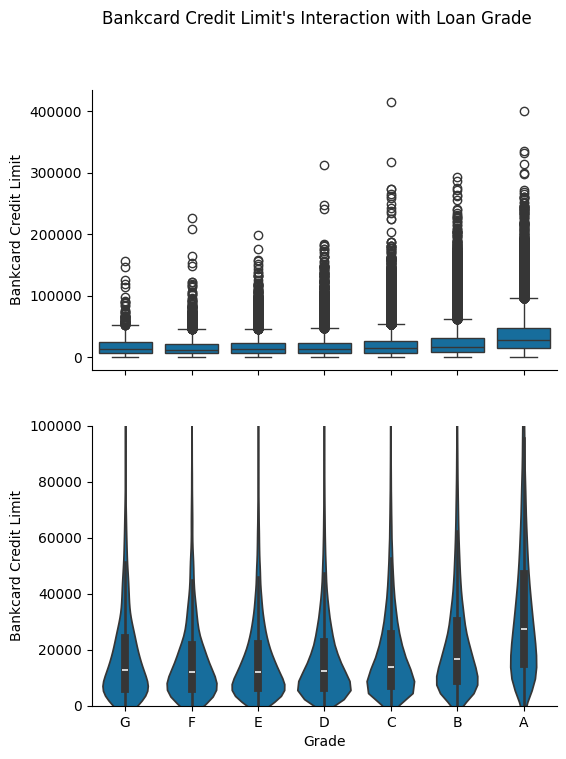

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
sns.boxplot(
    data=df_acc_sample.select(["total_bc_limit", "grade"]),
    y="total_bc_limit",
    x="grade",
    ax=ax[0],
    order=constants.grade_order,
)
sns.violinplot(
    data=df_acc_sample.select(["total_bc_limit", "grade"]),
    y="total_bc_limit",
    x="grade",
    ax=ax[1],
    order=constants.grade_order,
)
ax[0].set_ylabel("Bankcard Credit Limit")
ax[1].set_ylabel("Bankcard Credit Limit")
ax[1].set_xlabel("Grade")
ax[1].set_ylim(0, 100_000)
plt.suptitle("Bankcard Credit Limit's Interaction with Loan Grade")
sns.despine()

In [22]:
print("Aggregations for total_bc_limit feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="total_bc_limit")

Aggregations for total_bc_limit feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,15000.0,27500.0,47200.0,399800.0,38889,1148,0.02952
"""B""",0.0,8900.0,16800.0,30300.0,293160.0,60804,1349,0.022186
"""C""",0.0,7200.0,14000.0,25500.0,414100.0,59856,985,0.016456
"""D""",0.0,6300.0,12300.0,22700.0,312300.0,29783,698,0.023436
"""E""",0.0,6200.0,12200.0,22100.0,198700.0,12500,374,0.02992
"""F""",0.0,6100.0,12142.5,21600.0,226400.0,3965,143,0.036066
"""G""",0.0,5800.0,12814.5,24200.0,156000.0,1154,56,0.048527


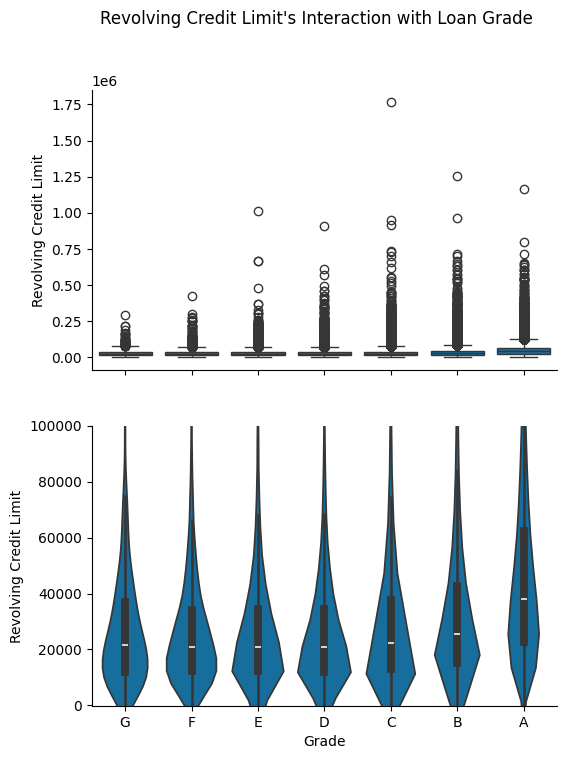

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
sns.boxplot(
    data=df_acc_sample.select(["total_rev_hi_lim", "grade"]),
    y="total_rev_hi_lim",
    x="grade",
    ax=ax[0],
    order=constants.grade_order,
)
sns.violinplot(
    data=df_acc_sample.select(["total_rev_hi_lim", "grade"]).filter(
        pl.col("total_rev_hi_lim") < 0.6e7
    ),
    y="total_rev_hi_lim",
    x="grade",
    ax=ax[1],
    order=constants.grade_order,
)
ax[0].set_ylabel("Revolving Credit Limit")
ax[1].set_ylabel("Revolving Credit Limit")
ax[1].set_xlabel("Grade")
ax[1].set_ylim(-100, 100_000)
plt.suptitle("Revolving Credit Limit's Interaction with Loan Grade")
sns.despine()

In [24]:
print("Aggregations for total_bc_limit feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="total_bc_limit")

Aggregations for total_bc_limit feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,15000.0,27500.0,47200.0,399800.0,38889,1148,0.02952
"""B""",0.0,8900.0,16800.0,30300.0,293160.0,60804,1349,0.022186
"""C""",0.0,7200.0,14000.0,25500.0,414100.0,59856,985,0.016456
"""D""",0.0,6300.0,12300.0,22700.0,312300.0,29783,698,0.023436
"""E""",0.0,6200.0,12200.0,22100.0,198700.0,12500,374,0.02992
"""F""",0.0,6100.0,12142.5,21600.0,226400.0,3965,143,0.036066
"""G""",0.0,5800.0,12814.5,24200.0,156000.0,1154,56,0.048527


Credit limit features also positively correlate with the grade. They also have higher null proportion for the lower grade loans.

#### Credit Utilisation

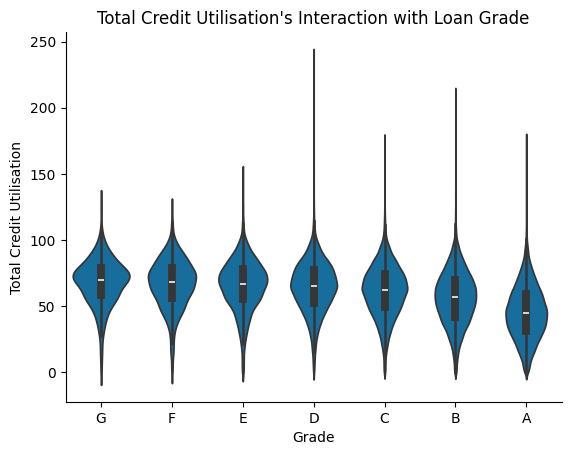

In [25]:
sns.violinplot(
    data=df_acc_sample.select(["all_util", "grade"]),
    y="all_util",
    x="grade",
    order=constants.grade_order,
)
plt.ylabel("Total Credit Utilisation")
plt.xlabel("Grade")
plt.title("Total Credit Utilisation's Interaction with Loan Grade")
sns.despine()

In [26]:
print("Aggregations for all_util feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="all_util")

Aggregations for all_util feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,31.0,45.0,59.0,175.0,38889,13737,0.353236
"""B""",0.0,42.0,57.0,70.0,210.0,60804,23674,0.389349
"""C""",0.0,49.0,62.0,74.0,175.0,59856,22828,0.381382
"""D""",0.0,52.0,65.0,77.0,239.0,29783,12973,0.435584
"""E""",0.0,55.0,67.0,78.0,149.0,12500,6645,0.5316
"""F""",0.0,56.0,68.0,79.0,123.0,3965,2164,0.545776
"""G""",0.0,58.0,70.0,79.0,128.0,1154,500,0.433276


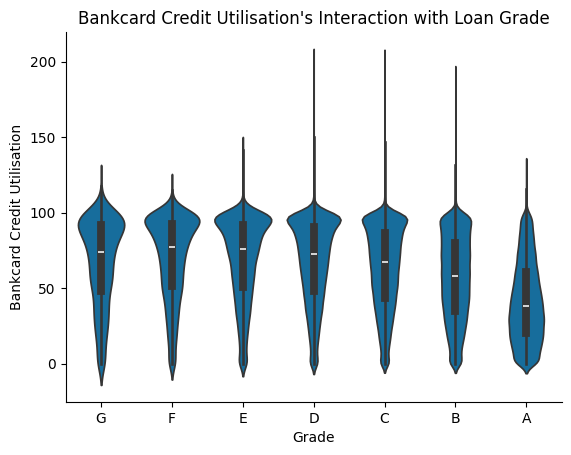

In [27]:
sns.violinplot(
    data=df_acc_sample.select(["bc_util", "grade"]),
    y="bc_util",
    x="grade",
    order=constants.grade_order,
)
plt.ylabel("Bankcard Credit Utilisation")
plt.xlabel("Grade")
plt.title("Bankcard Credit Utilisation's Interaction with Loan Grade")
sns.despine()

In [28]:
print("Aggregations for bc_util feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="bc_util")

Aggregations for bc_util feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,20.0,38.1,60.4,129.7,38889,1395,0.035871
"""B""",0.0,35.1,58.1,80.0,191.0,60804,1955,0.032152
"""C""",0.0,43.5,67.3,86.8,201.9,59856,1717,0.028686
"""D""",0.0,48.3,72.5,90.2,201.6,29783,1131,0.037975
"""E""",0.0,50.5,75.9,92.1,141.8,12500,597,0.04776
"""F""",0.0,51.1,77.0,92.7,115.1,3965,230,0.058008
"""G""",0.0,48.0,74.0,91.5,117.5,1154,69,0.059792


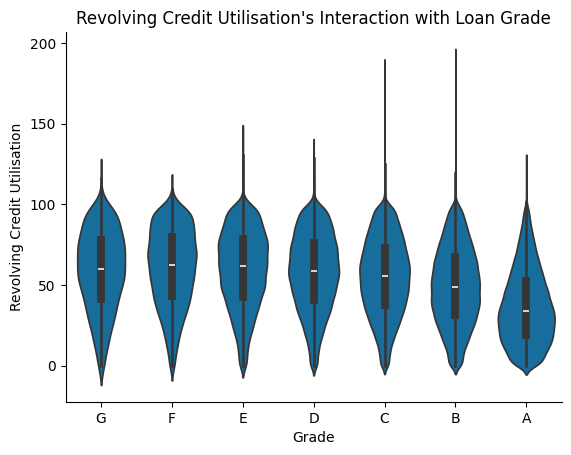

In [29]:
sns.violinplot(
    data=df_acc_sample.select(["revol_util", "grade"]),
    y="revol_util",
    x="grade",
    order=constants.grade_order,
)
plt.ylabel("Revolving Credit Utilisation")
plt.xlabel("Grade")
plt.title("Revolving Credit Utilisation's Interaction with Loan Grade")
sns.despine()

In [30]:
print("Aggregations for revol_util feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="revol_util")

Aggregations for revol_util feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,19.1,34.0,52.3,125.3,38889,21,0.00054
"""B""",0.0,31.1,48.8,67.0,191.0,60804,35,0.000576
"""C""",0.0,37.4,55.3,72.7,184.6,59856,57,0.000952
"""D""",0.0,40.8,58.9,76.1,134.4,29783,32,0.001074
"""E""",0.0,42.7,61.5,78.2,141.8,12500,6,0.00048
"""F""",0.0,43.1,62.5,80.0,109.3,3965,10,0.002522
"""G""",0.0,41.4,60.0,78.0,116.1,1154,0,0.0


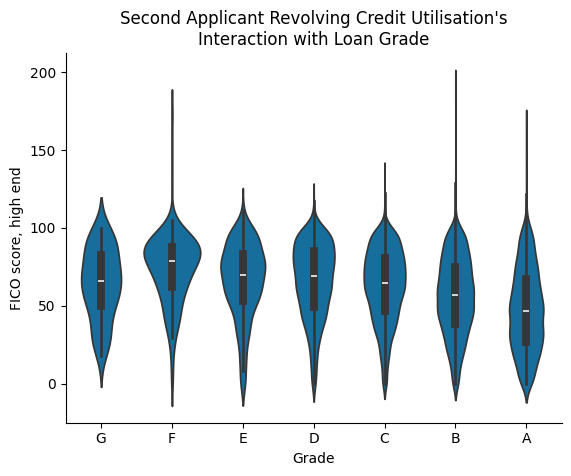

In [31]:
sns.violinplot(
    data=df_acc_sample.select(["sec_app_revol_util", "grade"]),
    y="sec_app_revol_util",
    x="grade",
    order=constants.grade_order,
)
plt.title(
    "Second Applicant Revolving Credit Utilisation's\nInteraction with Loan Grade"
)
plt.xlabel("Grade")
plt.ylabel("FICO score, high end")
sns.despine()

In [32]:
print("Aggregations for sec_app_revol_util feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="sec_app_revol_util")

Aggregations for sec_app_revol_util feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,27.1,46.55,67.2,163.9,38889,37147,0.955206
"""B""",0.0,38.6,56.9,75.2,191.0,60804,58293,0.958703
"""C""",0.0,46.9,64.8,80.8,132.3,59856,57089,0.953772
"""D""",0.0,49.6,69.1,85.0,117.1,29783,28478,0.956183
"""E""",0.0,52.8,69.9,83.6,111.7,12500,12005,0.9604
"""F""",2.0,61.1,78.6,88.0,172.7,3965,3822,0.963934
"""G""",18.0,50.0,65.7,83.8,99.7,1154,1096,0.94974


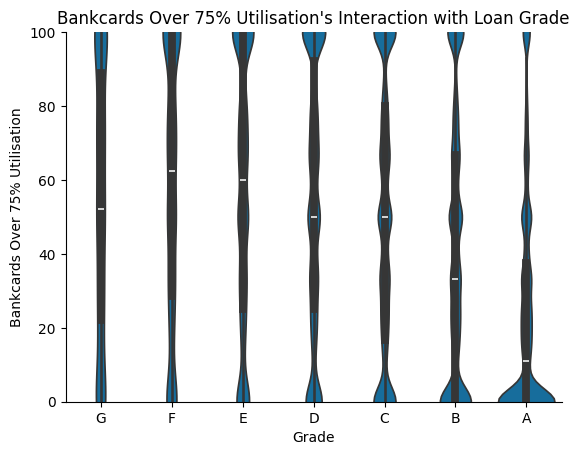

In [33]:
sns.violinplot(
    data=df_acc_sample.select(["percent_bc_gt_75", "grade"]),
    y="percent_bc_gt_75",
    x="grade",
    order=constants.grade_order,
)
plt.ylabel("Bankcards Over 75% Utilisation")
plt.xlabel("Grade")
plt.title("Bankcards Over 75% Utilisation's Interaction with Loan Grade")
plt.gca().set_ylim(0, 100)
sns.despine()

In [34]:
print("Aggregations for percent_bc_gt_75 feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="percent_bc_gt_75")

Aggregations for percent_bc_gt_75 feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,0.0,11.1,37.5,100.0,38889,1375,0.035357
"""B""",0.0,0.0,33.3,66.7,100.0,60804,1934,0.031807
"""C""",0.0,16.7,50.0,80.0,100.0,59856,1709,0.028552
"""D""",0.0,25.0,50.0,92.3,100.0,29783,1127,0.03784
"""E""",0.0,25.0,60.0,100.0,100.0,12500,592,0.04736
"""F""",0.0,28.6,62.5,100.0,100.0,3965,225,0.056747
"""G""",0.0,22.2,52.25,88.9,100.0,1154,68,0.058925


Generally, the lower the credit utilisation, the greater the loan grade. Also, lower grade loans tend to more often have missing values for some of these features.

The last feature (Bankcards Over 75% Utilisation) is a bit different then all the other features so far, as it has an interesting distribution. Applicants of higher grade loans tend to have this feature at 0, while those of lower grades - near 100.

#### DTI

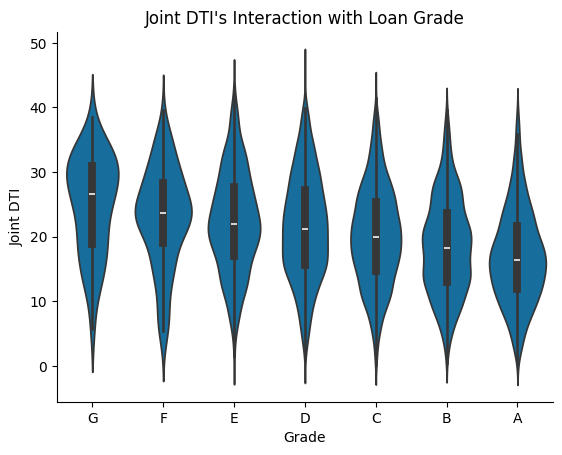

In [35]:
sns.violinplot(
    data=df_acc_sample.select(["dti_joint", "grade"]),
    y="dti_joint",
    x="grade",
    order=constants.grade_order,
)
plt.ylabel("Joint DTI")
plt.xlabel("Grade")
plt.title("Joint DTI's Interaction with Loan Grade")
sns.despine()

In [36]:
print("Aggregations for dti_joint feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="dti_joint")

Aggregations for dti_joint feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.27,11.84,16.36,21.62,39.77,38889,37010,0.951683
"""B""",0.52,12.99,18.3,23.74,39.97,60804,57935,0.952816
"""C""",0.13,14.69,19.94,25.43,42.46,59856,56567,0.945051
"""D""",1.03,15.64,21.18,27.25,45.39,29783,28195,0.946681
"""E""",1.46,17.02,21.975,27.73,43.13,12500,11916,0.95328
"""F""",3.13,19.03,23.71,28.34,39.58,3965,3792,0.956368
"""G""",5.65,18.91,26.665,31.12,38.57,1154,1090,0.944541


Even though joint DTI correlates well with the targets, it has a very high null proportion.

Even though regular debt over income doesn't make the cut for "correlation over 0.2", let's still explore it.

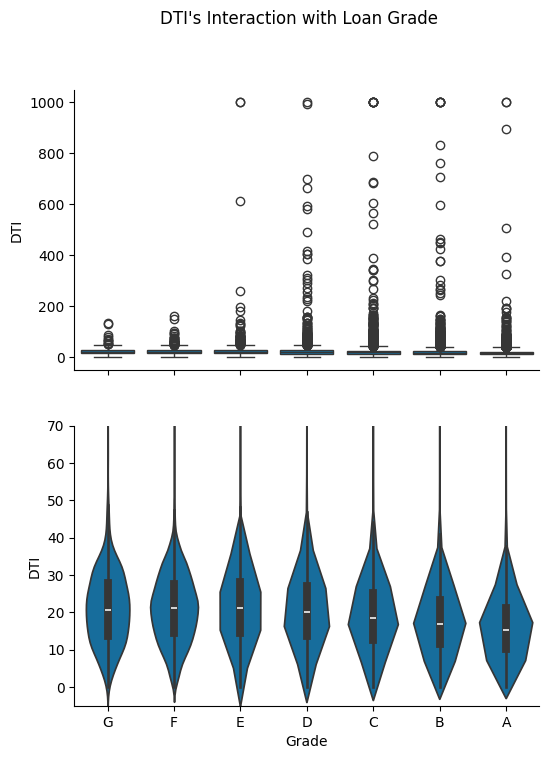

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
sns.boxplot(
    data=df_acc_sample.select(["dti", "grade"]),
    y="dti",
    x="grade",
    ax=ax[0],
    order=constants.grade_order,
)
sns.violinplot(
    data=df_acc_sample.select(["dti", "grade"]),
    y="dti",
    x="grade",
    ax=ax[1],
    order=constants.grade_order,
)
ax[0].set_ylabel("DTI")
ax[1].set_ylabel("DTI")
ax[1].set_xlabel("Grade")
ax[1].set_ylim(-5, 70)
plt.suptitle("DTI's Interaction with Loan Grade")
sns.despine()

In [38]:
print("Aggregations for dti feature")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="dti")

Aggregations for dti feature


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,10.08,15.22,21.15,999.0,38889,25,0.000643
"""B""",0.0,11.4,16.99,23.28,999.0,60804,34,0.000559
"""C""",0.0,12.65,18.6,25.23,999.0,59856,47,0.000785
"""D""",0.0,13.68,20.12,26.95,999.0,29783,24,0.000806
"""E""",0.0,14.36,21.08,28.12,999.0,12500,10,0.0008
"""F""",0.0,14.44,21.08,27.66,159.79,3965,4,0.001009
"""G""",0.0,13.75,20.65,27.87,132.73,1154,0,0.0


Regular DTI seems to correlate with the target similar to that of joint DTI, but has far more extreme values. Seems like DTI is capped at 999.

#### Loan Amount

I'll continue exploring some of the features that didn't make the cut, but are more interesting for me to explore.

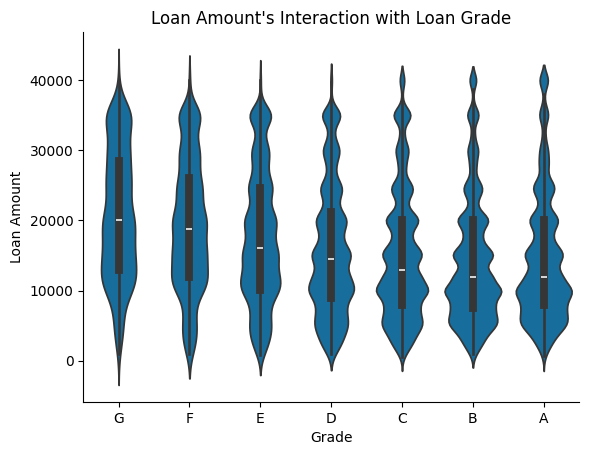

In [39]:
sns.violinplot(
    data=df_acc_sample.select(["loan_amnt", "grade"]),
    y="loan_amnt",
    x="grade",
    order=constants.grade_order,
)
plt.ylabel("Loan Amount")
plt.xlabel("Grade")
plt.title("Loan Amount's Interaction with Loan Grade")
sns.despine()

In [40]:
print("Aggregations for loan_amnt")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="loan_amnt")

Aggregations for loan_amnt


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",725.0,8000.0,12000.0,20000.0,40000.0,38889,0,0.0
"""B""",1000.0,7500.0,12000.0,20000.0,40000.0,60804,0,0.0
"""C""",600.0,8000.0,13000.0,20000.0,40000.0,59856,0,0.0
"""D""",1000.0,8875.0,14500.0,21250.0,40000.0,29783,0,0.0
"""E""",800.0,10100.0,16000.0,24700.0,40000.0,12500,0,0.0
"""F""",1000.0,12000.0,18750.0,26000.0,40000.0,3965,0,0.0
"""G""",1000.0,13000.0,20000.0,28500.0,40000.0,1154,0,0.0


Loan amount is hard capped at 40k for accepted loans. Just looking at the numbers seems like a nice feature to predict the lower grades.

#### Employment Length

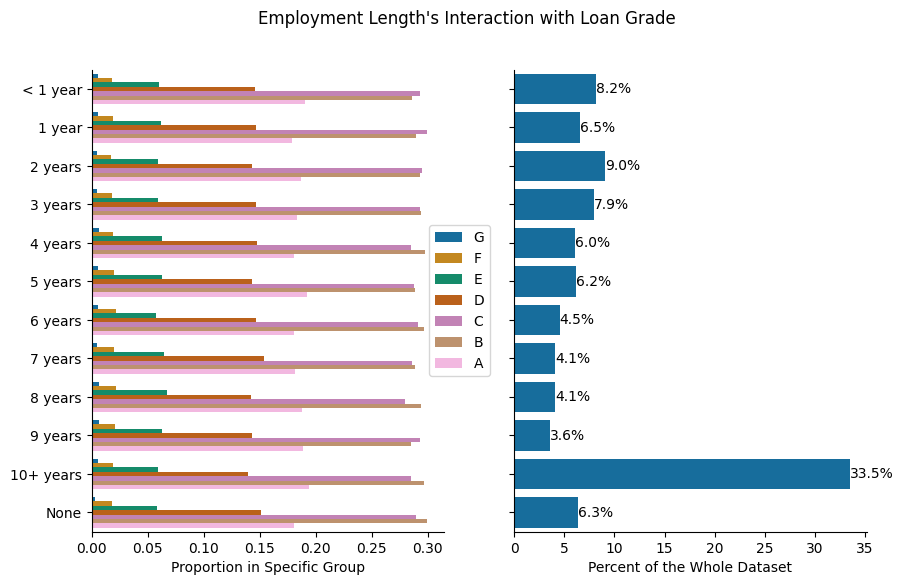

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(
    df_acc_sample,
    x="emp_length",
    hue="grade",
    order=constants.emp_length_order_eda,
    hue_order=constants.grade_order,
    ax=ax,
)
ax[0].legend(loc="right", bbox_to_anchor=(1.15, 0.5))
plt.suptitle("Employment Length's Interaction with Loan Grade")
plt.show()

Contrary to what we saw in step 2, the major part of those with accepted loans are in the 10+ group. And even though the figure is a bit convoluted, it can be seen that there doesn't seem to be an evident relation between the loan grade and employment length.

#### Home Ownership

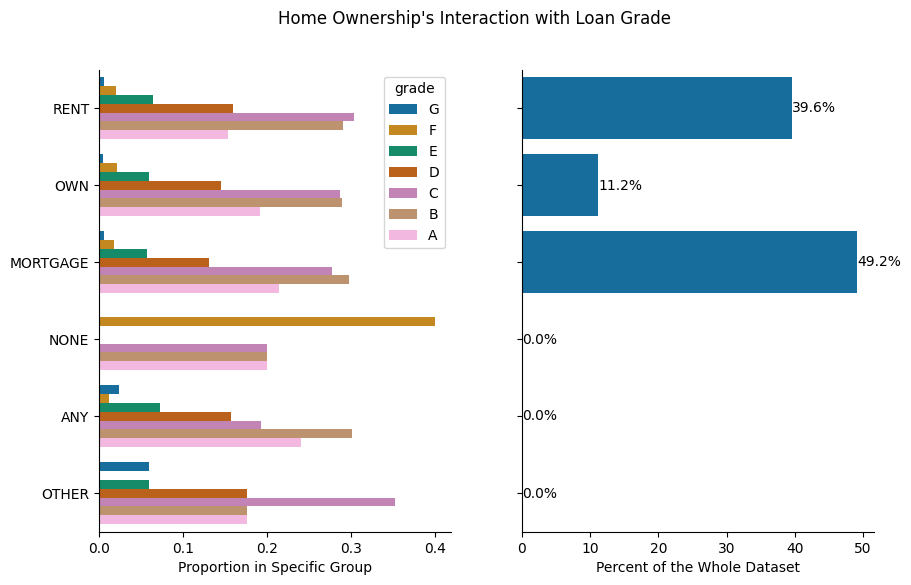

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
home_own_order = ["RENT", "OWN", "MORTGAGE", "NONE", "ANY", "OTHER"]
functions.norm_plot(
    df_acc_sample,
    x="home_ownership",
    hue="grade",
    order=home_own_order,
    hue_order=constants.grade_order,
    ax=ax,
)
plt.suptitle("Home Ownership's Interaction with Loan Grade")
plt.show()

There are very little appearances of NONE, ANY, OTHER. We would want to group these into one group at least, or even add to the most frequent group. Looking at the remaining three groups, there seems to be an effect where RENT < OWN < MORTGAGE judging by the increase in A, B grade loans and decrease of lower grade loans.

#### Annual income

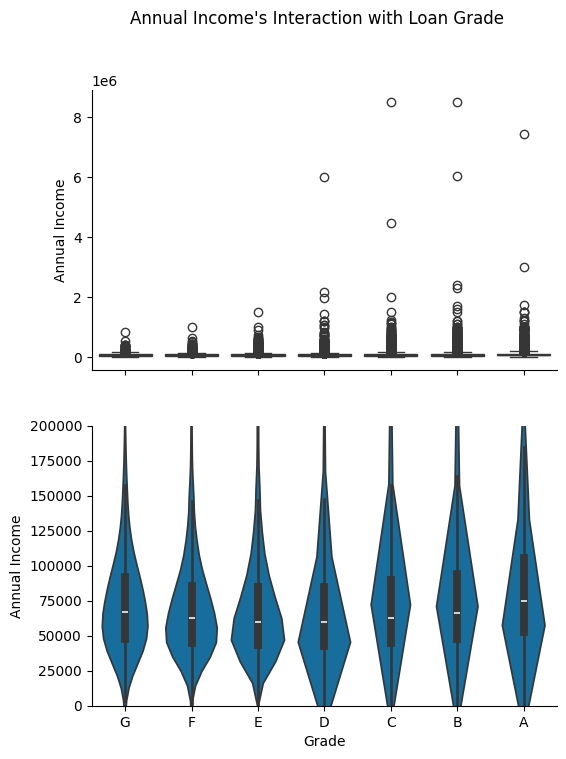

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
sns.boxplot(
    data=df_acc_sample.select(["annual_inc", "grade"]),
    y="annual_inc",
    x="grade",
    ax=ax[0],
    order=constants.grade_order,
)
sns.violinplot(
    data=df_acc_sample.select(["annual_inc", "grade"]),
    y="annual_inc",
    x="grade",
    ax=ax[1],
    order=constants.grade_order,
)
ax[0].set_ylabel("Annual Income")
ax[1].set_ylabel("Annual Income")
ax[1].set_xlabel("Grade")
ax[1].set_ylim(0, 200_000)
plt.suptitle("Annual Income's Interaction with Loan Grade")
sns.despine()

In [44]:
print("Aggregations for annual_inc")
functions.aggregations_by_group(df_acc_sample, by="grade", agg_for="annual_inc")

Aggregations for annual_inc


grade,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
str,f64,f64,f64,f64,f64,u32,u32,f64
"""A""",0.0,53000.0,75000.0,105830.0,7.446395e6,38889,1,0.000026
"""B""",0.0,47747.0,66000.0,94308.0,8.500021e6,60804,0,0.0
"""C""",0.0,45000.0,63000.0,90000.0,8.5e6,59856,0,0.0
"""D""",0.0,42961.0,60000.0,85000.0,6e6,29783,0,0.0
"""E""",0.0,43600.0,60000.0,85000.0,1.5e6,12500,0,0.0
"""F""",0.0,45000.0,63000.0,85500.0,995000.0,3965,0,0.0
"""G""",3200.0,48000.0,67100.0,92000.0,825000.0,1154,0,0.0


"A" grade loans stand out by the higher statistics. Looking at the extreme values, higher grade loans seem to be given for those with very large income. Otherwise, doesn't seem like a very good feature.

#### Verification Status

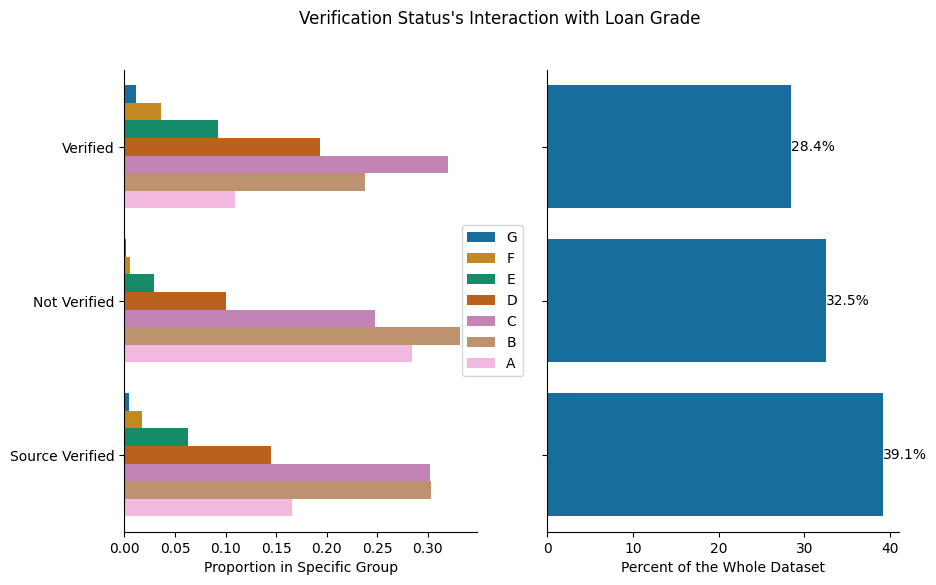

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(
    df_acc_sample,
    x="verification_status",
    hue="grade",
    hue_order=constants.grade_order,
    ax=ax,
)
ax[0].legend(loc="right", bbox_to_anchor=(1.15, 0.5))
plt.suptitle("Verification Status's Interaction with Loan Grade")
plt.show()

Looking at the figure it seems that Not Verified > Source Verified > Verified, which is odd. ChatGPT told that usually Source verified is the best verification status, and by common sense Verified should be better than not verified. Perhaps there are other things at play here - maybe verification is not that important for the company and is more frequently imposed on those that are less trustworthy?

#### Disbursement Method

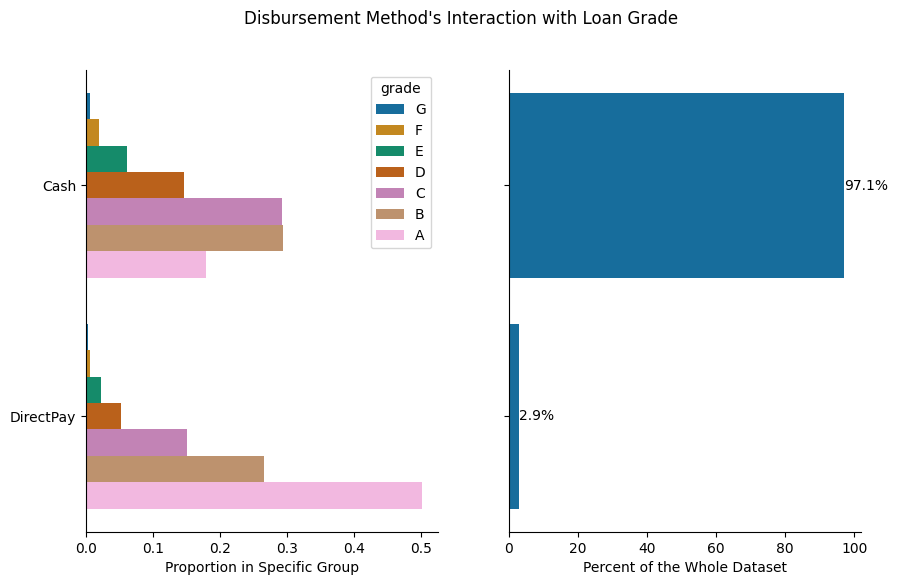

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(
    df_acc_sample,
    x="disbursement_method",
    hue="grade",
    hue_order=constants.grade_order,
    ax=ax,
)
plt.suptitle("Disbursement Method's Interaction with Loan Grade")
plt.show()

Those that use DirectPay seem to fall into "A" grade much more frequently. However, the proportion is quite small.

#### Null Values in "Months Since..." Features

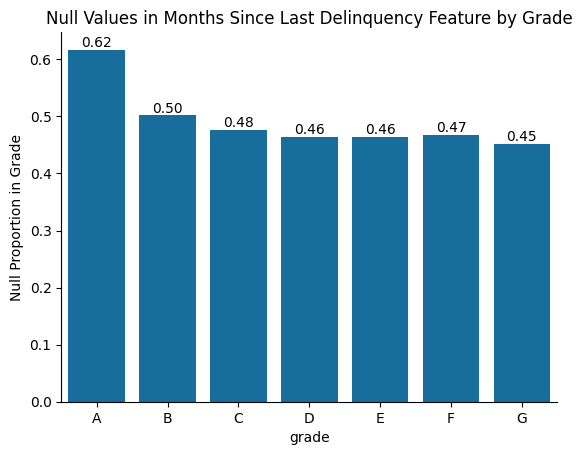

In [47]:
agg_delinq = functions.aggregations_by_group(
    df_acc_sample, by="grade", agg_for="mths_since_last_delinq"
)
sns.barplot(agg_delinq.to_pandas(), x="grade", y="null_proportion")
functions.add_labels(fmt="%1.2f")
plt.title("Null Values in Months Since Last Delinquency Feature by Grade")
plt.ylabel("Null Proportion in Grade")
sns.despine()

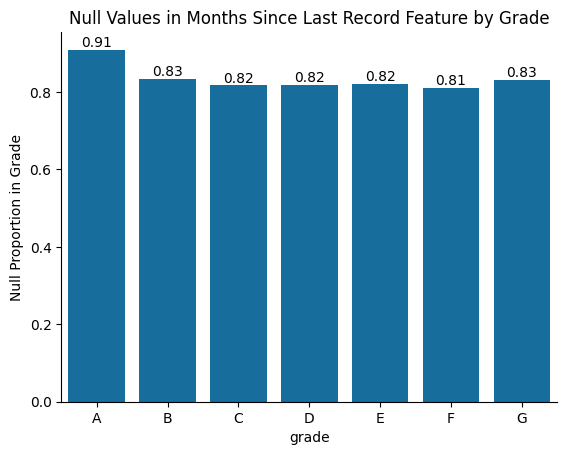

In [48]:
agg_record = functions.aggregations_by_group(
    df_acc_sample, by="grade", agg_for="mths_since_last_record"
)
sns.barplot(agg_record.to_pandas(), x="grade", y="null_proportion")
functions.add_labels(fmt="%1.2f")
plt.title("Null Values in Months Since Last Record Feature by Grade")
plt.ylabel("Null Proportion in Grade")
sns.despine()

As observed before, some features tend to have a greater null proportion for lower-grade loans, but this is reversed for these two features.

The observed phenomenon could be explained by what the null value actually encodes. A "0" for these features would mean that the applicant has had an event this month. Thus, a null value is chosen to encode "this has never happened before", and obviously some events, especially a delinquency at any point in time drastically reduces applicant trustworthiness.

#### Title and Purpose

Let's clean the text first. Title can be aggregated this way a bit, but purpose has no need for it, there's only 14 unique values.

In [49]:
df_acc_sample_clean = functions.clean_text_in_cols(df_acc_sample, ["title"])

In [50]:
top_5_titles = (
    df_acc_sample_clean.select("title")
    .to_series()
    .value_counts(sort=True)
    .to_pandas()
    .head(5)
)
top_5_titles_count = top_5_titles["counts"].sum()
total_count = df_acc_sample_clean.height
top_5_titles_proportion = top_5_titles_count / total_count
print(
    f"Top 5 titles in the dataset (when they are cleant) take approximately {top_5_titles_proportion*100:2.2f}% of all the titles"
)
top_5_titles

Top 5 titles in the dataset (when they are cleant) take approximately 86.31% of all the titles


,title,counts
0,debtconsolidation,107583
1,creditcardrefinancing,42339
2,homeimprovement,12846
3,other,11653
4,majorpurchase,4194


In [51]:
top_5_purposes = (
    df_acc_sample_clean.select("purpose")
    .to_series()
    .value_counts(sort=True)
    .to_pandas()
    .head(5)
)
top_5_purposes_count = top_5_purposes["counts"].sum()
total_count = df_acc_sample_clean.height
top_5_purposes_proportion = top_5_purposes_count / total_count
print(
    f"Top 5 purposes in the dataset (when they are cleant) take approximately {top_5_purposes_proportion*100:2.2f}% of all the purposes"
)
top_5_purposes

Top 5 purposes in the dataset (when they are cleant) take approximately 94.39% of all the purposes


,purpose,counts
0,debt_consolidation,117273
1,credit_card,46817
2,home_improvement,13779
3,other,12805
4,major_purchase,4671


Purposes and titles seem to match very closely, but purpose feature only has 14 unique values and has no null values.

### Statistical Inference

Statistical inference tests could be applied to many of the features that we explored up until now. As an example, I'd like to explore whether the impact of purpose on grade is statistically significant.

Population: representative 10% sample of the dataset stratified by grade.

Null hypothesis: the distributions of loan grades within top 5 purposes are drawn from the same distribution.

Alternative hypothesis: the distributions of loan grades within top 5 purposes are different.

Significance level: 95%.

In [52]:
population = df_acc_sample.select(["int_rate", "grade", "purpose"])
population = population.filter(
    pl.col("purpose").is_in(top_5_purposes["purpose"].to_list())
)

means = population.group_by("purpose").agg(pl.mean("int_rate"))
means.sort("int_rate")

purpose,int_rate
str,f64
"""credit_card""",11.70628
"""home_improveme…",12.59333
"""major_purchase…",12.688591
"""debt_consolida…",13.525308
"""other""",14.168375


Just by looking at the interest rates, it seems that the purpose feature has an impact on the target.

In [55]:
pd.crosstab(population["purpose"], population["grade"], normalize="index")

grade,A,B,C,D,E,F,G
purpose,,,,,,,
credit_card,0.266228,0.344170,0.253049,0.096162,0.030993,0.007583,0.001816
debt_consolidation,0.157419,0.283382,0.304998,0.157794,0.068362,0.021812,0.006233
home_improvement,0.227448,0.290732,0.278685,0.128166,0.054213,0.015821,0.004935
major_purchase,0.225219,0.298009,0.265254,0.131663,0.056519,0.016485,0.006851
other,0.144241,0.245061,0.300351,0.187427,0.084889,0.028817,0.009215


We can see that the proportions of loan grades are quite different. The most notable purpose is "other", which has notably less A and B grade loans and notably more of the other grades.

In [53]:
population = population.to_pandas()
table = pd.crosstab(population["purpose"], population["grade"]).values
chi, pval, _, _ = stats.chi2_contingency(table)
print(f"chi2 statistic: {chi:.2f}")
print(f"p-value: {pval:.4f}")

chi2 statistic: 5916.32
p-value: 0.0000


With a chi2 statistic this high, we can with 95% confidence reject the null hypothesis and state that the distributions of grades within the top 5 purposes are different. 

## This Notebook's Output

We have achieved the goals of this notebook:
- The three targets (grade, subgrade, interest rate) are closely correlated.
- There are some features to drop due to leakage from the future, some - due to high collinearity.
- There are a lot of high (A, B, C) grade loans and very few of the worst ones.
- We have some features correlated with the targets. Many of the best features seem to matter for high grade loans though.
- The missing values in the dataset seem to often be of MNAR nature. Either there's more nulls for the high or for the low grade loans, depending on what the missing value encodes.